KEYSTROKE DYNAMICS ANALYSIS AND PREDICTION

Keystroke dynamics basically deals with the analysis of keystroke patterns of a user. In one of its use cases, this can essentially enable companies to provide non-intrusive real-time authentication of users.

By capturing the duration between 2 key presses, the duration of pressing down a key, and the duration between the current key release and the next key press can provide great insights about the user. The next time this user logs in, by comparing his current typing pattern with his previous typing patterns, companies can authenticate whether the logged in user is legitimate or fraudulent.



The dataset Keystroke dynamics challenge 1 | Kaggle has been used in this notebook. This dataset captures typing attempts of 110 users. Each user has attempted 8 times to type the string 'united states' and the corresponding timestamps of key press and release relative to the first key press have been captured.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")


In [ ]:
trainDF = pd.read_csv("/content/train.csv")
testDF = pd.read_csv("/content/test.csv")
the=pd.read_csv("/content/submit[1].csv")

In [ ]:
trainDF.head()


,user,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,...,press-8,release-8,press-9,release-9,press-10,release-10,press-11,release-11,press-12,release-12
0,1,0,120,216,312,424,496,592,664,808,...,1712,1760,1992,2064,2376,2448,2584,2632,2752,2824
1,1,0,95,168,265,360,455,527,599,736,...,1423,1471,1664,1711,1880,1952,2039,2111,2231,2279
2,1,0,71,143,231,783,903,1087,1159,1351,...,2039,2111,2271,2343,2487,2559,2679,2751,2871,2926
3,1,0,95,144,263,353,431,760,832,1159,...,3151,3223,3415,3463,3631,3703,3815,3887,3983,4055
4,1,0,70,166,238,310,406,526,598,710,...,1310,1382,1543,1605,1734,1806,1926,1998,2086,2182


In [ ]:
testDF.head()


,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,release-4,...,press-8,release-8,press-9,release-9,press-10,release-10,press-11,release-11,press-12,release-12
0,0,96,239,337,407,537,740,839,928,1047,...,1831,1951,2032,2138,2430,2496,2567,2691,2824,2919
1,0,87,248,319,515,590,734,803,912,983,...,1839,1911,2103,2174,2383,2487,2575,2647,2815,2886
2,0,90,234,312,404,512,667,767,843,940,...,1572,1675,1771,1890,1948,2043,2147,2255,2540,2683
3,0,193,240,356,407,526,607,732,712,769,...,1600,1728,1744,1832,1904,2063,2148,2258,2336,2501
4,0,74,324,394,555,629,926,1026,1194,1328,...,2626,2754,2922,3068,3154,3259,3386,3453,3618,3698


In [ ]:
print('No. of rows in training dataset:',len(trainDF))
print('No. of users for which training data is present:',trainDF.user.nunique())

No. of rows in training dataset: 880
No. of users for which training data is present: 110


In [ ]:
print('No. of rows in test dataset:',len(testDF))

No. of rows in test dataset: 220


**GENERATE FILES**

Now, by itself, these timestamps would mean nothing. We can gain insights on user typing patterns by creating features such as press-press duration (PPD), hold duration (HD), release-press duration (RPD).


In [ ]:
trainDF1 = trainDF
for i in range(1,13):
    trainDF1['PPD-'+str(i)] = trainDF1['press-'+str(i)] - trainDF1['press-'+str(i-1)]
    trainDF1['RPD-'+str(i)] = trainDF1['release-'+str(i)] - trainDF1['press-'+str(i-1)]

for i in range(13):
    trainDF1['HD-'+str(i)] = trainDF1['release-'+str(i)] - trainDF1['press-'+str(i)]

testDF1 = testDF
for i in range(1,13):
    testDF1['PPD-'+str(i)] = testDF1['press-'+str(i)] - testDF1['press-'+str(i-1)]
    testDF1['RPD-'+str(i)] = testDF1['release-'+str(i)] - testDF1['press-'+str(i-1)]

for i in range(13):
    testDF1['HD-'+str(i)] = testDF1['release-'+str(i)] - testDF1['press-'+str(i)]

In [ ]:
trainDF1.head()

,user,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,...,HD-3,HD-4,HD-5,HD-6,HD-7,HD-8,HD-9,HD-10,HD-11,HD-12
0,1,0,120,216,312,424,496,592,664,808,...,72,48,72,96,48,48,72,72,48,72
1,1,0,95,168,265,360,455,527,599,736,...,72,71,71,71,56,48,47,72,72,48
2,1,0,71,143,231,783,903,1087,1159,1351,...,72,103,72,96,79,72,72,72,72,55
3,1,0,95,144,263,353,431,760,832,1159,...,72,48,50,91,47,72,48,72,72,72
4,1,0,70,166,238,310,406,526,598,710,...,72,48,72,96,72,72,62,72,72,96


**EDA**

Let's now perform an exploratory data analysis on these features to understand the significant features.

In [ ]:
# Check stats of first 5 users i.e. 5 x 8 typing patterns
noOfUsers = 5
if noOfUsers == -1:
    trainDF2 = trainDF1
else:
    trainDF2 = trainDF1[:noOfUsers*8]

In [ ]:
temp1 = pd.DataFrame({'Min':trainDF2.min(),'Max':trainDF2.max()})
temp1.head()

,Min,Max
user,1,5
press-0,0,0
release-0,0,120
press-1,0,253
release-1,78,360


**Scatterplot of PPD vs RPD**

Let's check how a scatterplot of RPD v/s PPD will look like. Note, PPD = HD + RPD. Thus, these should be almost linearly related which is evident from the following plot

Text(0.5, 1.0, 'Scatterplot of PPD vs RPD')

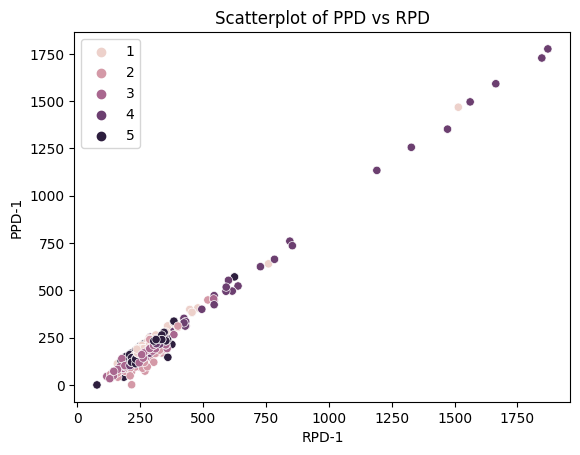

In [ ]:
for i in range(1,13):
    ax = sns.scatterplot(x='RPD-'+str(i),y='PPD-'+str(i),hue='user',data=trainDF2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:noOfUsers], labels[:trainDF2.user.nunique()])
ax.set_title('Scatterplot of PPD vs RPD')

**Swarm Plots of RPD, PPD, HD**

Next, let's analyse the swarmplots of RPD, PPD, HD for each user. Since, there are 8 typing patterns per user and each typing pattern consists of 13 key strokes, we have 8 x 13 = 104 data points per user.

Here, we are using an interesting feature of seaborn charts. Now, since we have 12 RPD values per typing pattern (consecutive pairs from 13 key presses), we need to visualise all these durations together. So, we invoke swarmplot for each of these 12 columns back-to-back and seaborn overlays the data from all of these visualisations together.

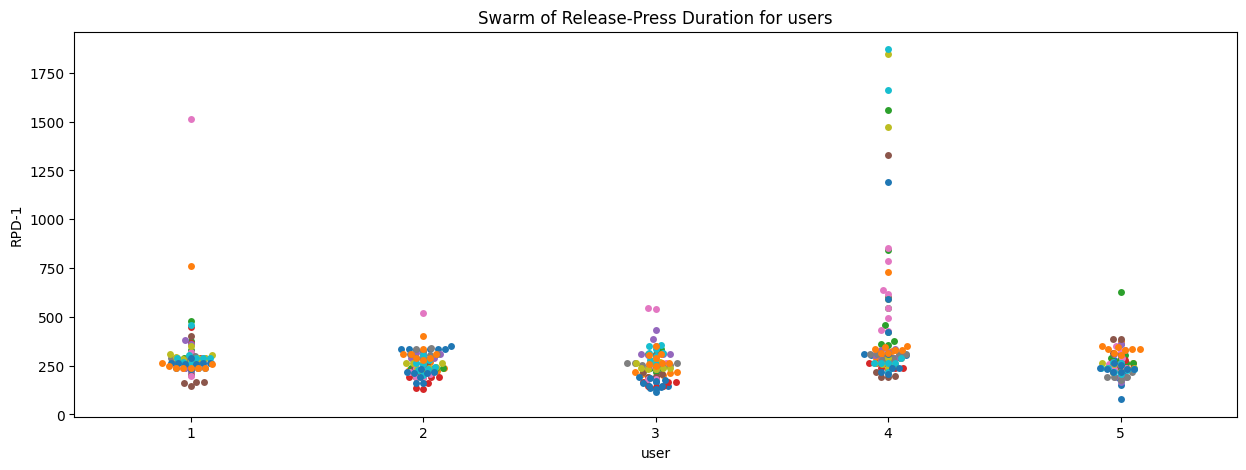

In [ ]:
plt.figure(figsize=(15,5))
for i in range(1,13):
    sns.swarmplot(y='RPD-'+str(i),x='user',data=trainDF2).set_title('Swarm of Release-Press Duration for users')

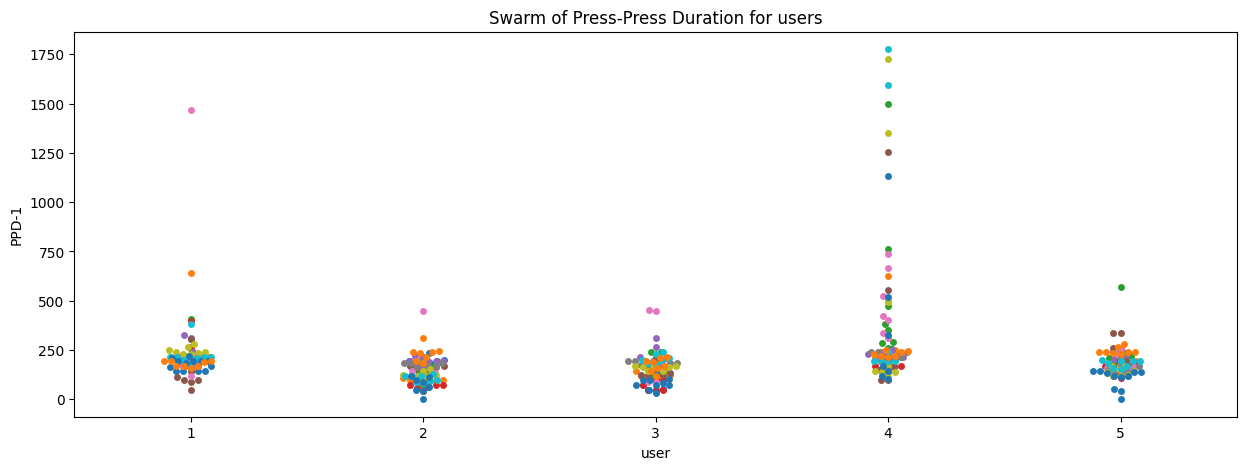

In [ ]:
plt.figure(figsize=(15,5))
for i in range(1,13):
    sns.swarmplot(y='PPD-'+str(i),x='user',data=trainDF2).set_title('Swarm of Press-Press Duration for users')

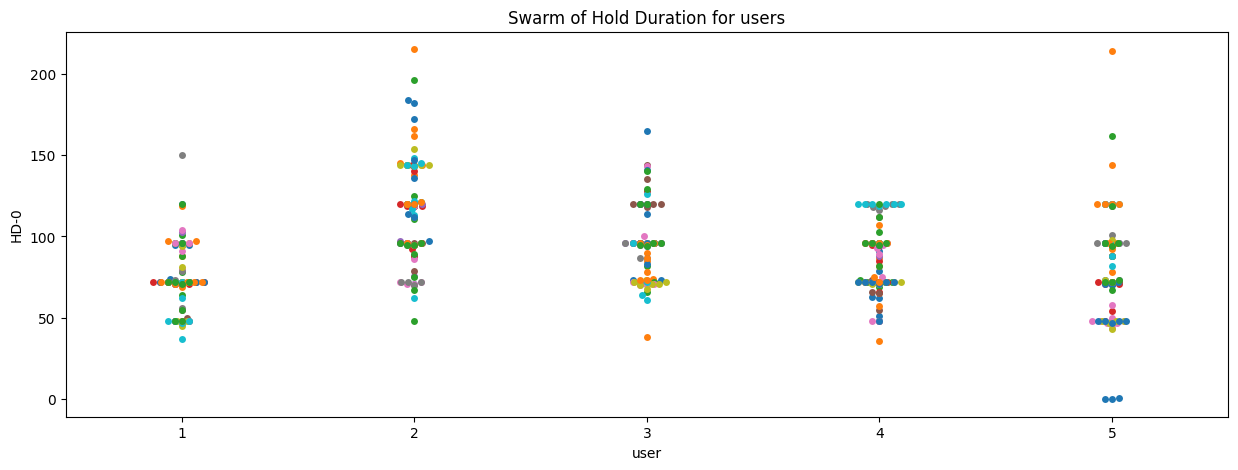

In [ ]:
plt.figure(figsize=(15,5))
for i in range(13):
    sns.swarmplot(y='HD-'+str(i),x='user',data=trainDF2).set_title('Swarm of Hold Duration for users')

As, you can see from the swarm plots, the press-press duration, release-press durations is roughly the same across all users. Thus, directly using an average duration will not be helpful.

However, hold duration is roughly different for each user which is correct since each user has a different typing speed according to his familiarity with typing.

**Further Analysis of HD, PPD, RPD by understanding key sequences**

ince we know that each typing pattern consists of 13 keystrokes, let's try to visualise scatter plots and line plots of how these durations would look in terms of the timestamps of key press events. Note, since each typing pattern is independent of the other, we construct 8 line plots (consisting of 13 data points) for each of the 5 users resulting in 8 x 5 = 40 line plots.





**Hold Duration key sequences**

Here, an interesting pandas function wide_to_long is used. In order to analyse these sequences, we need all these durations to present in 1 column as against spread across multiple columns of a row. So, wide_to_long stacks all these values present in multiple columns into a single column. By sorting in the sequence: user,id,key_no, we ensure that all durations of a single typing pattern are together.

In [ ]:
# value_vars_cols = ['HD-'+str(i) for i in range(13)]

drop_cols_HD_analysis = ['PPD-'+str(i) for i in range(1,13)] + ['RPD-'+str(i) for i in range(1,13)] + ['release-'+str(i) for i in range(13)]

trainDF_HD_analysis = trainDF2.drop(columns=drop_cols_HD_analysis)
trainDF_HD_analysis['id'] = trainDF_HD_analysis.index
trainDF_HD_analysis = pd.wide_to_long(trainDF_HD_analysis,['press-','HD-'],i='id',j='key_no').sort_values(by=['user','id','key_no'])
trainDF_HD_analysis

user  press-  HD-
id key_no                   
0  0          1       0  120
   1          1     216   96
   2          1     424   72
   3          1     592   72
   4          1     808   48
...         ...     ...  ...
39 8          5    1267   43
   9          5    1420   82
   10         5    1574   72
   11         5    1710   96
   12         5    1950   73

[520 rows x 3 columns]

<Axes: xlabel='press-', ylabel='HD-'>

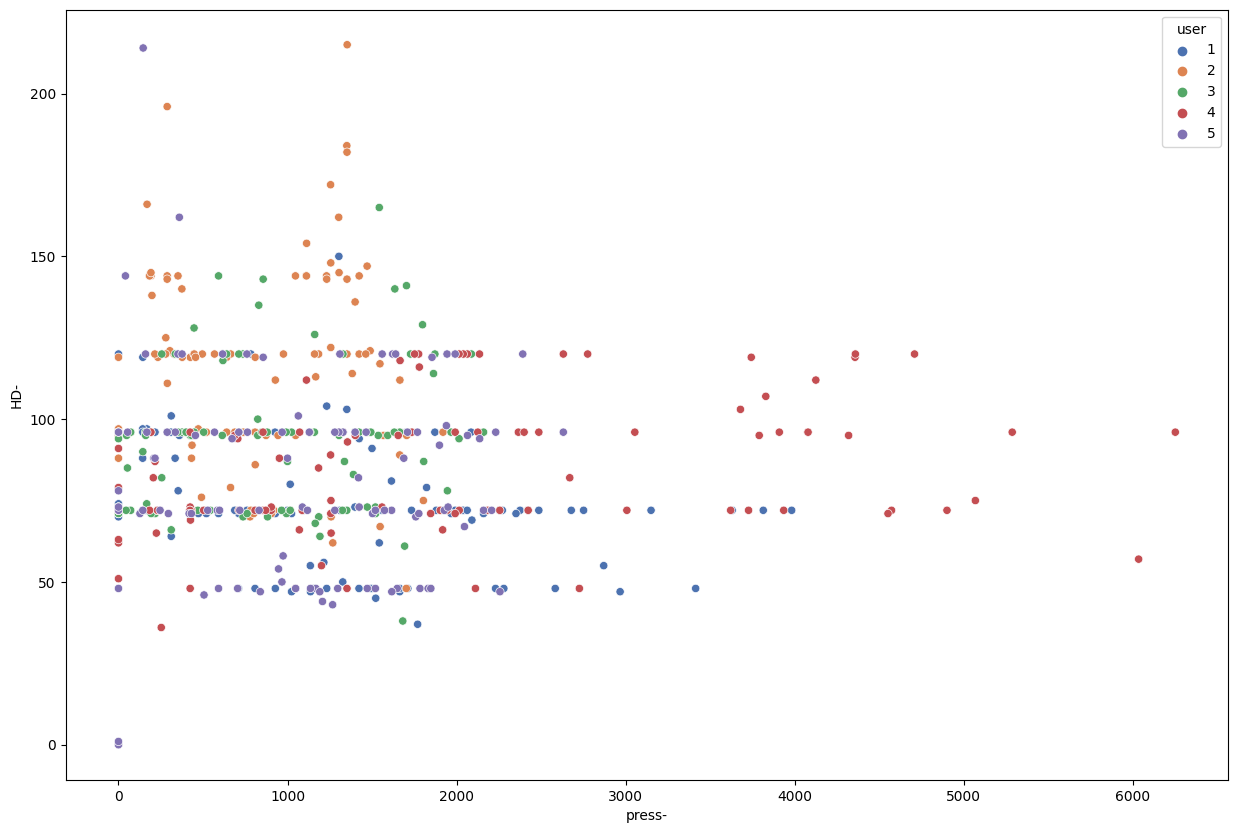

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='press-',y='HD-',hue='user',data=trainDF_HD_analysis,palette='deep')

Text(0.5, 1.0, 'Line plots for each key sequence')

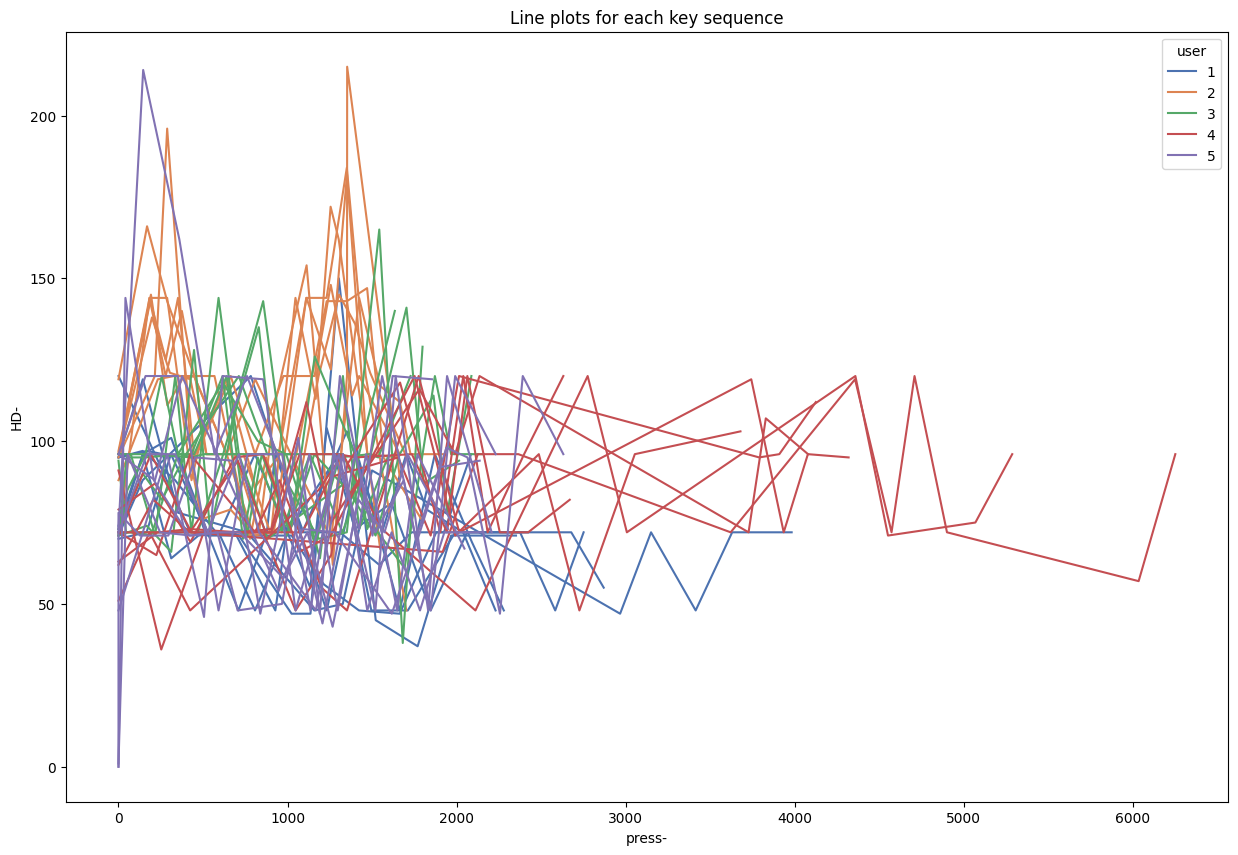

In [ ]:
plt.figure(figsize=(15,10))
# sns.load_dataset(trainDF_HD_analysis)
sns.lineplot(x='press-',y='HD-',hue='user',units='id',estimator=None,data=trainDF_HD_analysis.reset_index(),palette='deep').set_title('Line plots for each key sequence')

**Press-Press Duration key sequences**

In [ ]:
# value_vars_cols = ['HD-'+str(i) for i in range(13)]

drop_cols_PPD_analysis = ['HD-'+str(i) for i in range(13)] + ['RPD-'+str(i) for i in range(1,13)] + ['release-'+str(i) for i in range(13)] + ['press-0']

trainDF_PPD_analysis = trainDF2.drop(columns=drop_cols_PPD_analysis)
trainDF_PPD_analysis['id'] = trainDF_PPD_analysis.index
trainDF_PPD_analysis = pd.wide_to_long(trainDF_PPD_analysis,['press-','PPD-'],i='id',j='key_no').sort_values(by=['user','id','key_no'])
# trainDF_PPD_analysis

<Axes: xlabel='press-', ylabel='PPD-'>

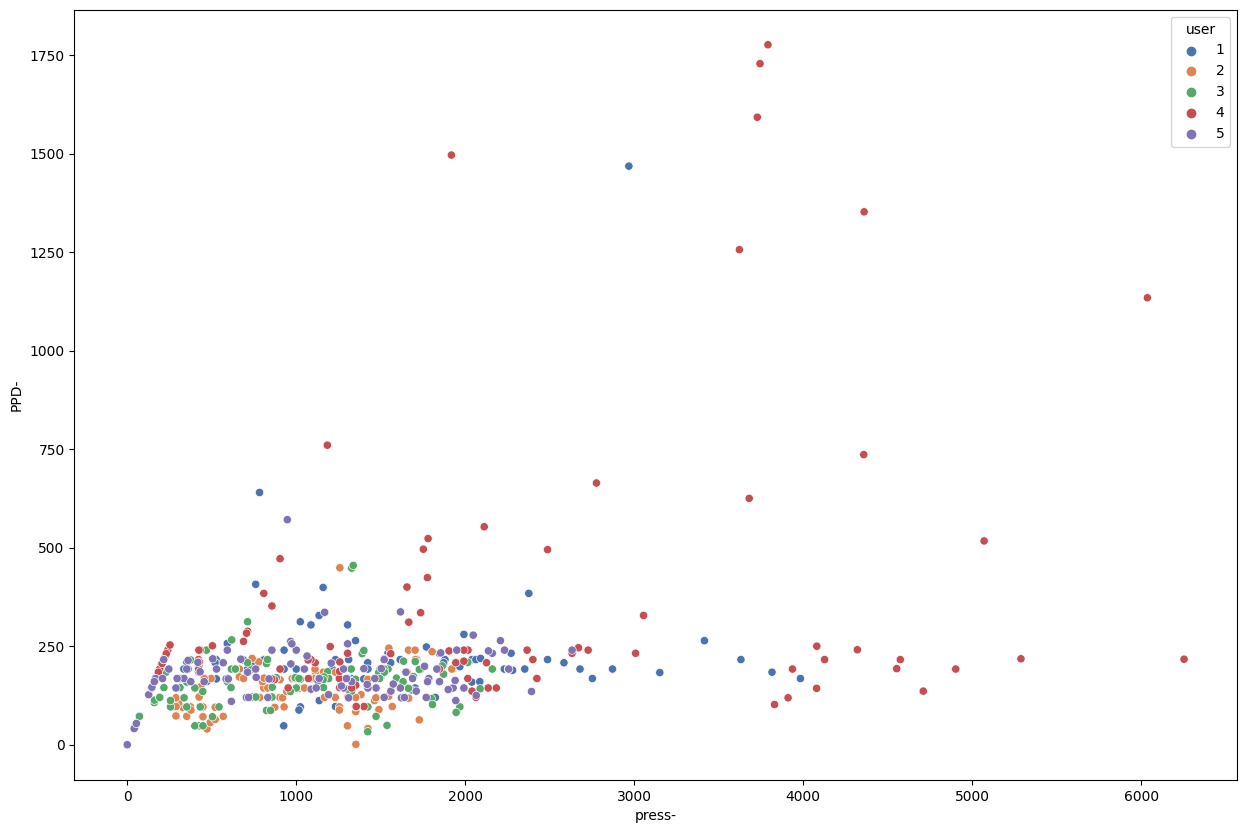

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='press-',y='PPD-',hue='user',data=trainDF_PPD_analysis,palette='deep')

Text(0.5, 1.0, 'Line plots for each key sequence')

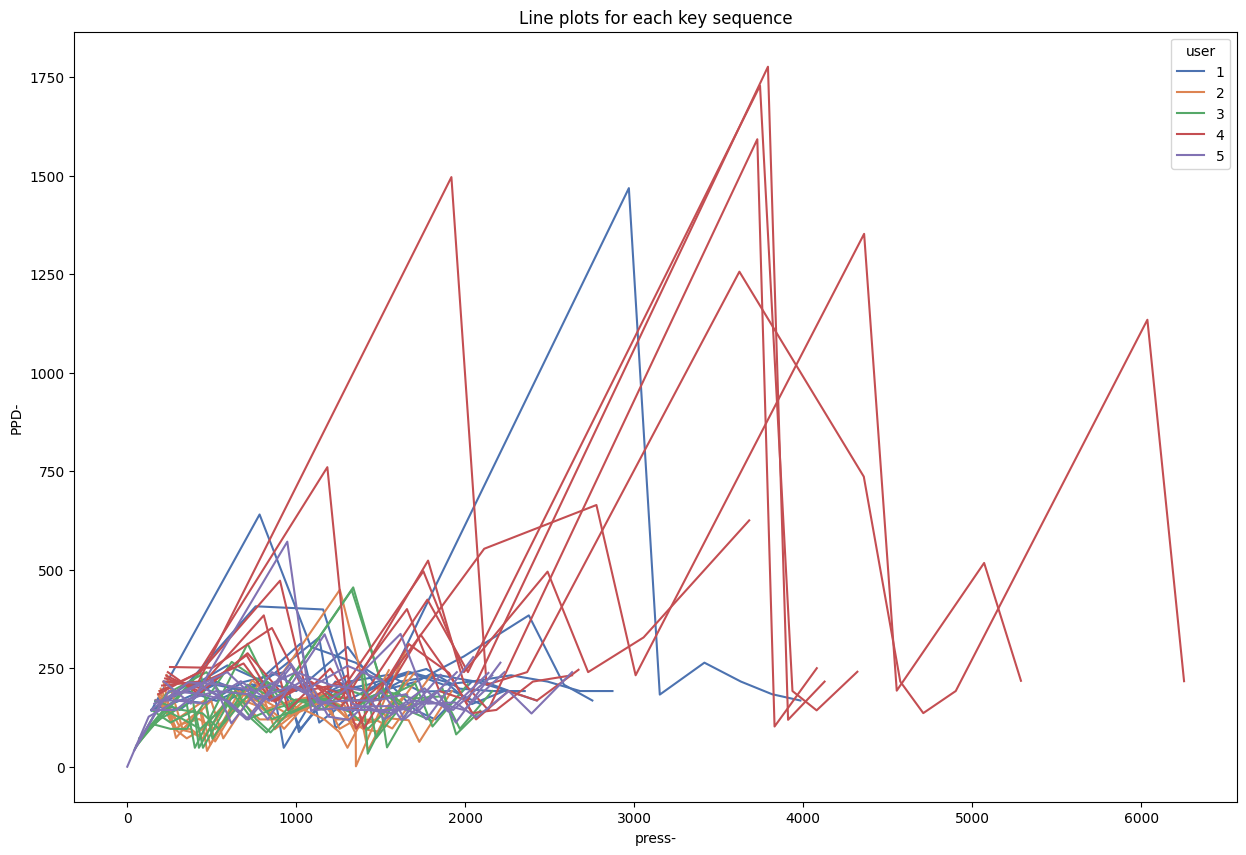

In [ ]:
plt.figure(figsize=(15,10))
# sns.load_dataset(trainDF_HD_analysis)
sns.lineplot(x='press-',y='PPD-',hue='user',units='id',estimator=None,data=trainDF_PPD_analysis.reset_index(),palette='deep').set_title('Line plots for each key sequence')

**This plot reveals a very interesting detail.**


Notice the jagged lines for user 4 (red lines). The PPD suddenly increases and then becomes very low for the next key. This means that this user waits for a relatively longer time before typing in 2 keys back to back. So, we could say this user typically types in groups of 2 keys

**Release-Press Duration key sequences**

In [ ]:
# value_vars_cols = ['HD-'+str(i) for i in range(13)]

drop_cols_RPD_analysis = ['HD-'+str(i) for i in range(13)] + ['PPD-'+str(i) for i in range(1,13)] + ['release-'+str(i) for i in range(13)] + ['press-0']

trainDF_RPD_analysis = trainDF2.drop(columns=drop_cols_RPD_analysis)
trainDF_RPD_analysis['id'] = trainDF_RPD_analysis.index
trainDF_RPD_analysis = pd.wide_to_long(trainDF_RPD_analysis,['press-','RPD-'],i='id',j='key_no').sort_values(by=['user','id','key_no'])
# trainDF_RPD_analysis

<Axes: xlabel='press-', ylabel='RPD-'>

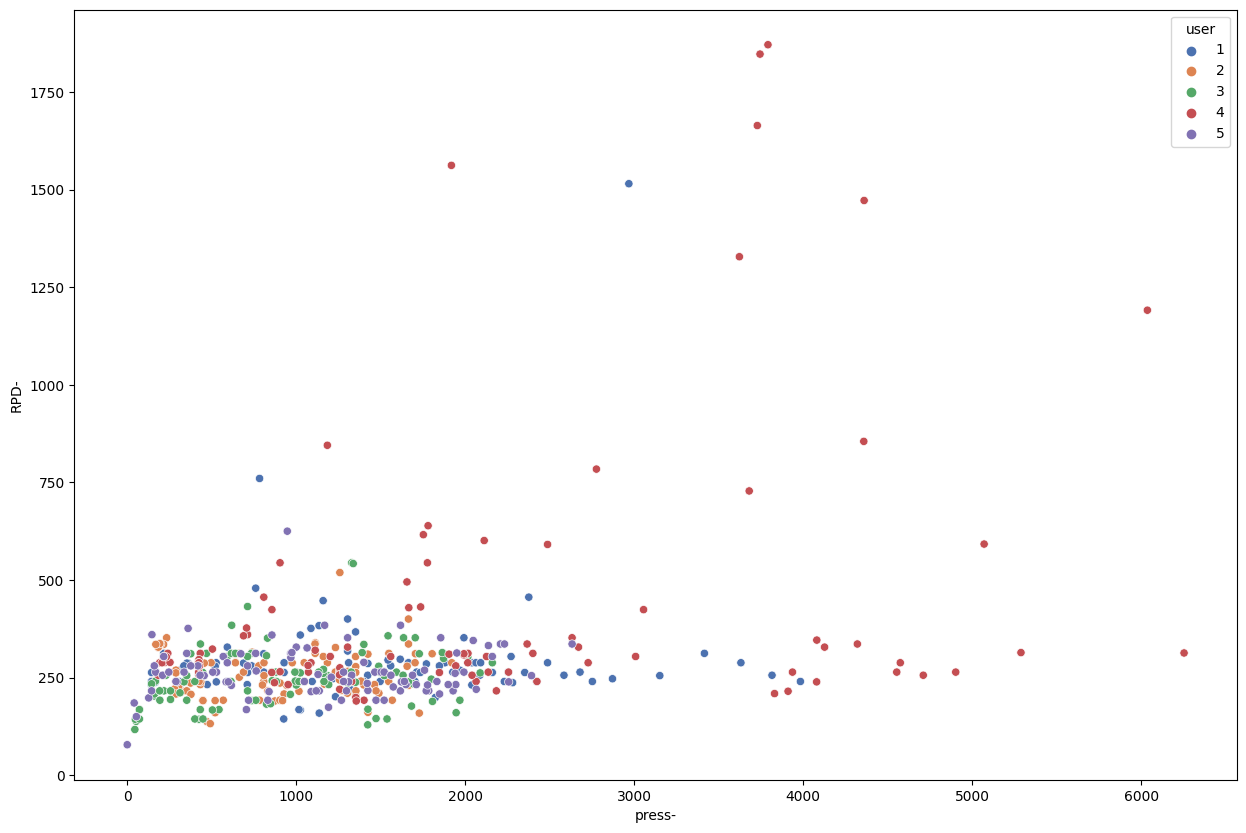

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='press-',y='RPD-',hue='user',data=trainDF_RPD_analysis,palette='deep')

Text(0.5, 1.0, 'Line plots for each key sequence')

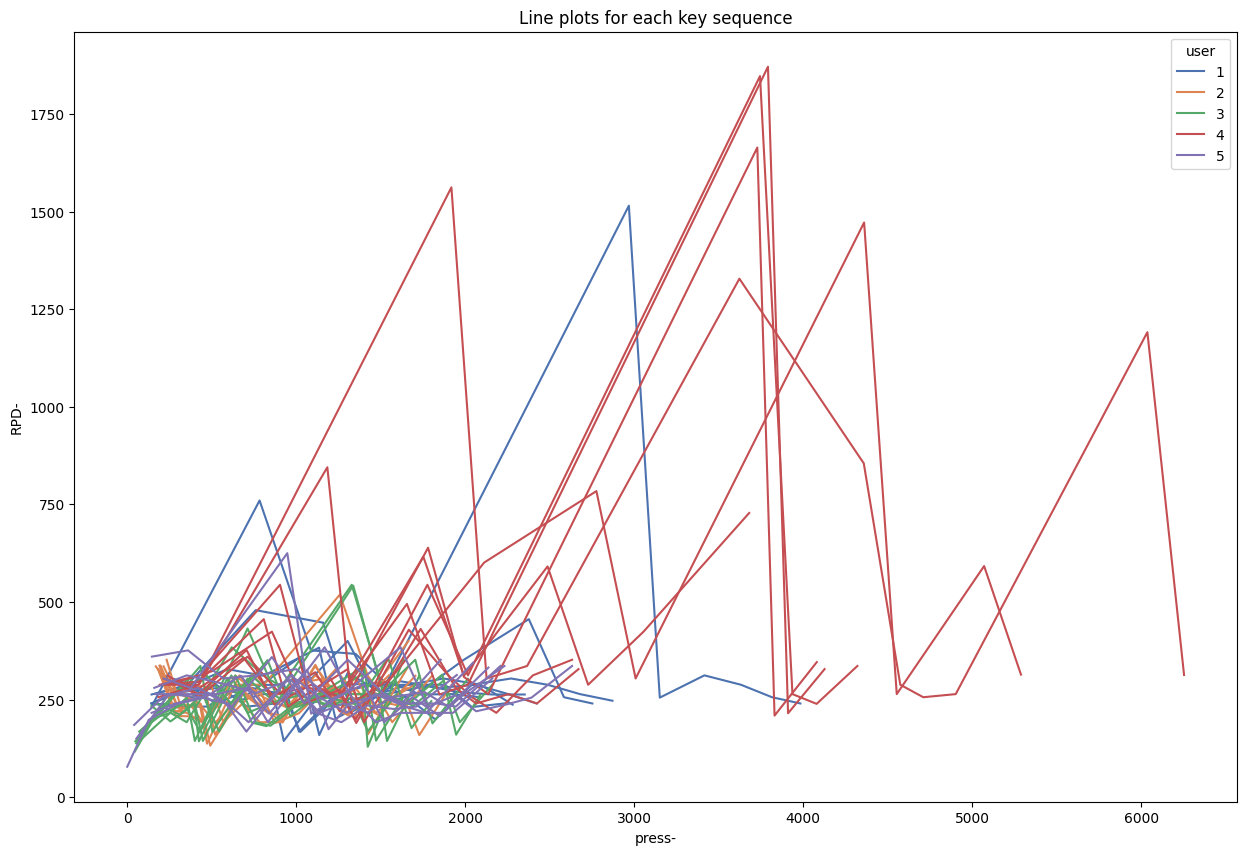

In [ ]:
plt.figure(figsize=(15,10))
# sns.load_dataset(trainDF_HD_analysis)
sns.lineplot(x='press-',y='RPD-',hue='user',units='id',estimator=None,data=trainDF_RPD_analysis.reset_index(),palette='deep').set_title('Line plots for each key sequence')

This plot reveals the same detail as PPD.

Notice the jagged lines for user 4. The RPD also suddenly increases and then becomes very low for the next key. This means that this user waits for a relatively longer time before typing in 2 keys back to back. So, we could say this user typically types in groups of 2 keys

In [ ]:
trainDF


,user,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,...,press-8,release-8,press-9,release-9,press-10,release-10,press-11,release-11,press-12,release-12
0,1,0,120,216,312,424,496,592,664,808,...,1712,1760,1992,2064,2376,2448,2584,2632,2752,2824
1,1,0,95,168,265,360,455,527,599,736,...,1423,1471,1664,1711,1880,1952,2039,2111,2231,2279
2,1,0,71,143,231,783,903,1087,1159,1351,...,2039,2111,2271,2343,2487,2559,2679,2751,2871,2926
3,1,0,95,144,263,353,431,760,832,1159,...,3151,3223,3415,3463,3631,3703,3815,3887,3983,4055
4,1,0,70,166,238,310,406,526,598,710,...,1310,1382,1543,1605,1734,1806,1926,1998,2086,2182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,110,0,80,225,306,444,465,575,672,689,...,1638,1735,1785,1884,1928,2040,2057,2186,2284,2504
876,110,0,81,217,289,387,473,954,1057,1091,...,1755,1866,1921,2019,2161,2265,2351,2457,2561,2704
877,110,0,79,216,300,393,519,692,807,807,...,1591,1724,1763,1866,1879,2046,2048,2192,2303,2449
878,110,0,84,200,290,384,476,782,930,943,...,1537,1658,1760,1848,1831,1940,1944,2082,2174,2319


In [ ]:
testDF

,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,release-4,...,press-8,release-8,press-9,release-9,press-10,release-10,press-11,release-11,press-12,release-12
0,0,96,239,337,407,537,740,839,928,1047,...,1831,1951,2032,2138,2430,2496,2567,2691,2824,2919
1,0,87,248,319,515,590,734,803,912,983,...,1839,1911,2103,2174,2383,2487,2575,2647,2815,2886
2,0,90,234,312,404,512,667,767,843,940,...,1572,1675,1771,1890,1948,2043,2147,2255,2540,2683
3,0,193,240,356,407,526,607,732,712,769,...,1600,1728,1744,1832,1904,2063,2148,2258,2336,2501
4,0,74,324,394,555,629,926,1026,1194,1328,...,2626,2754,2922,3068,3154,3259,3386,3453,3618,3698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,0,96,250,313,413,512,849,1033,933,1049,...,1785,1856,2088,2160,2422,2568,2472,2616,2682,2813
216,0,85,196,263,384,458,491,618,631,719,...,1361,1419,1456,1535,1591,1659,1727,1818,1994,2041
217,0,88,251,332,415,536,641,828,829,885,...,3931,4049,4354,4448,4593,4753,4769,4853,4889,4993
218,0,96,144,264,240,336,480,576,552,648,...,2064,2135,2256,2306,2472,2544,2520,2591,2735,2799


In [ ]:
col=trainDF.columns

In [ ]:
trainDF.shape

(880, 27)

In [ ]:
df=trainDF[trainDF['user']<=20]

In [ ]:
df.iloc[:,:-1].describe()

,user,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,...,release-7,press-8,release-8,press-9,release-9,press-10,release-10,press-11,release-11,press-12
count,160.000000,160.0,160.000000,160.000000,160.000000,160.000000,160.000000,160.00000,160.000000,160.000000,...,160.000000,160.000000,160.000000,160.000000,160.000000,160.00000,160.000000,160.000000,160.000000,160.000000
mean,10.500000,0.0,71.893750,167.275000,261.206250,375.562500,462.875000,642.40000,737.868750,790.787500,...,1575.806250,1691.931250,1778.031250,1876.343750,1966.331250,2106.38125,2203.581250,2260.075000,2352.831250,2465.550000
std,5.784386,0.0,33.735485,90.951777,107.700732,352.025883,355.889226,438.36268,446.490017,460.992577,...,625.703825,675.345494,673.082606,739.163696,741.861578,808.07409,807.419723,857.833453,858.593498,901.537916
min,1.000000,0.0,0.000000,0.000000,1.000000,1.000000,2.000000,2.00000,4.000000,14.000000,...,804.000000,882.000000,978.000000,1071.000000,1170.000000,1255.00000,1364.000000,1303.000000,1465.000000,1548.000000
25%,5.750000,0.0,64.000000,97.750000,216.000000,275.500000,359.750000,454.50000,566.500000,568.000000,...,1224.000000,1315.750000,1393.250000,1464.750000,1544.250000,1648.75000,1733.250000,1764.500000,1862.750000,1941.000000
50%,10.500000,0.0,72.000000,184.500000,266.500000,336.000000,432.000000,559.00000,640.000000,736.000000,...,1424.000000,1520.000000,1592.000000,1656.000000,1756.000000,1861.50000,1967.500000,1995.500000,2102.500000,2186.000000
75%,15.250000,0.0,95.250000,215.250000,312.000000,423.250000,496.000000,711.00000,807.250000,875.750000,...,1761.500000,1886.750000,1950.000000,2045.750000,2160.000000,2260.00000,2368.750000,2472.500000,2554.750000,2665.500000
max,20.000000,0.0,166.000000,544.000000,664.000000,4333.000000,4453.000000,4549.00000,4717.000000,4813.000000,...,5549.000000,5645.000000,5759.000000,5865.000000,5945.000000,6265.00000,6413.000000,6351.000000,6483.000000,6998.000000


Timestamps are increasing of press and release so all the statistical data would be also increasing.


In [ ]:
target_value = 0  # Replace with the value you're searching for
d_f=df.drop(columns='press-0')
# Iterate through rows and columns
for index, row in d_f.iterrows():
    for col_index, cell_value in enumerate(row):
        if cell_value == target_value:
            print(f"Value {target_value} found at row {index}, column {col_index}")

Value 0 found at row 33, column 1
Value 0 found at row 34, column 1
Value 0 found at row 34, column 2
Value 0 found at row 111, column 1
Value 0 found at row 117, column 1
Value 0 found at row 147, column 1
Value 0 found at row 148, column 1
Value 0 found at row 148, column 2
Value 0 found at row 155, column 1


Finding the zero values that are present in the data of 20 users except the ones that are in press-0. Cause starting timestamp would obviously be zero but if any other than press-0 would be 0, it would mean only two things first user had not pressed that key or user had pressed another key in place of mentioned key.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,confusion_matrix

from sklearn.preprocessing import KBinsDiscretizer

from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.special import entr

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
train_1 = trainDF
for i in range(1,13):
    train_1['PPD-'+str(i)] = train_1['press-'+str(i)] - train_1['press-'+str(i-1)]


    train_1['RPD-'+str(i)] = train_1['press-'+str(i)] - train_1['release-'+str(i-1)]

for i in range(13):
    train_1['HD-'+str(i)] = train_1['release-'+str(i)] - train_1['press-'+str(i)]

In [ ]:
test_1 = testDF
for i in range(1,13):
    test_1['PPD-'+str(i)] = test_1['press-'+str(i)] - test_1['press-'+str(i-1)]


    test_1['RPD-'+str(i)] = test_1['press-'+str(i)] - test_1['release-'+str(i-1)]

for i in range(13):
    test_1['HD-'+str(i)] = test_1['release-'+str(i)] - test_1['press-'+str(i)]

In [ ]:
train_1

,user,press-0,release-0,press-1,release-1,press-2,release-2,press-3,release-3,press-4,...,HD-3,HD-4,HD-5,HD-6,HD-7,HD-8,HD-9,HD-10,HD-11,HD-12
0,1,0,120,216,312,424,496,592,664,808,...,72,48,72,96,48,48,72,72,48,72
1,1,0,95,168,265,360,455,527,599,736,...,72,71,71,71,56,48,47,72,72,48
2,1,0,71,143,231,783,903,1087,1159,1351,...,72,103,72,96,79,72,72,72,72,55
3,1,0,95,144,263,353,431,760,832,1159,...,72,48,50,91,47,72,48,72,72,72
4,1,0,70,166,238,310,406,526,598,710,...,72,48,72,96,72,72,62,72,72,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,110,0,80,225,306,444,465,575,672,689,...,97,95,156,123,137,97,99,112,129,220
876,110,0,81,217,289,387,473,954,1057,1091,...,103,98,154,81,103,111,98,104,106,143
877,110,0,79,216,300,393,519,692,807,807,...,115,87,200,118,105,133,103,167,144,146
878,110,0,84,200,290,384,476,782,930,943,...,148,35,176,110,71,121,88,109,138,145


In [ ]:
red=train_1
for i in range (0,13):
  red=red.drop(columns='press-'+str(i))
  red=red.drop(columns='release-'+str(i))

In [ ]:
tes=test_1
for i in range (0,13):
  tes=tes.drop(columns='press-'+str(i))
  tes=tes.drop(columns='release-'+str(i))

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
X=trainDF.drop(columns='user')
Y=trainDF['user']

In [ ]:
# Set the threshold for variance
threshold = 0.1

# Create an instance of VarianceThreshold
var_selector = VarianceThreshold(threshold=threshold)

# Fit and transform the data
X_new = var_selector.fit_transform(X)

# Get the support mask
support_mask = var_selector.get_support()

In [ ]:
Yxgb=Y-1

In [ ]:
X=X.drop(columns='press-0')

In [ ]:
X = pd.DataFrame(X_new,
index=X.index,
columns=X.columns)

 XGB is computationally expensive algorithhm hence downcasting our columns to a smaller datatypes

Speed up our ML by downcasting the data types

In [ ]:
int_features = X.select_dtypes(include='int64').columns

In [ ]:
#float_features = X.select_dtypes(include='float64').columns
X[int_features] = X[int_features].apply(pd.to_numeric, downcast='signed')
#X[float_features] = X[float_features].apply(pd.to_numeric, downcast='signed')
Y = Y.apply(pd.to_numeric, downcast='signed')

In [ ]:
kbin = KBinsDiscretizer(n_bins=25, encode='ordinal', strategy='kmeans')
kbin.fit(X)
X = pd.DataFrame(kbin.transform(X),columns=trainDF.loc[:, (trainDF.columns != 'user') & (trainDF.columns != 'press-0') ].columns)

In [ ]:
model = XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3, use_label_encoder=False,
              min_child_weight=3, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nthread=4, num_class=110,
              num_parallel_tree=1, objective='multi:softmax', predictor='auto',
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=30, subsample=0.5, tree_method='exact', verbosity=0, silent=True)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
model = model.fit(X, Yxgb)
Y_pred = model.predict(data_test.drop(columns='press-0'))


Accuracy = accuracy_score(the-1,Y_pred)
print(round(Accuracy*100,2))

0.45

 `0.45`

In [ ]:
model = RandomForestClassifier(n_estimators = 100,max_features = 'sqrt',bootstrap = True,random_state =1,n_jobs=-1)

In [ ]:
model = model.fit(X, Yxgb)
Y_pred = model.predict(data_test.drop(columns='press-0'))


Accuracy = accuracy_score(the-1,Y_pred)
print(round(Accuracy*100,2))

`0.91`




In [ ]:
model=LinearSVC()

In [ ]:
model = model.fit(X, Yxgb)
Y_pred = model.predict(data_test.drop(columns='press-0'))


Accuracy = accuracy_score(the-1,Y_pred)
print(round(Accuracy*100,2))

```
0.91
```






